# Bidirectional LSTM time series classification 
- Predict Google stock prices given last 10 years of data (2010 - 2020)

- This notebook is inspired by the following tutorials:
    - https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/03.stock_prediction.ipynb
    - https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    - https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
    - https://towardsdatascience.com/aifortrading-2edd6fac689d


# A. Setup

### A.1 Get more ram on google colab

In [1]:
more_ram = True
gpu= True

In [2]:
# 1. Set run time to GPU
# code to crash colab and get more ram
if not more_ram:
    a = []
    while(1):
        a.append(1)

### A.2 Load libraries and variables


In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
label_col = "google"
date_col = "Date"
scale_type = "minmax"
features_list = ["google", "microsoft", "nvidia", "nasdaq", "volatility", "apple", "amazon"]
time_steps = 100

# activate GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### A.3 Fix randomness for reproducible results

In [5]:
# Fix random number for reproducible results
seed_value= 0

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

tf.random.set_seed(seed_value)

### A.4 Load dataset

https://finance.yahoo.com/quote/GOOG/history?period1=1568325161&period2=1599947561&interval=1d&filter=history&frequency=1d

- This dataset is obtained from yahoo finance stock price history (09-12-2010 to 09-12-2020)
- To predict Google stock prices, we will also look at:

1) other tech companies similar to google (Amazon, Microsoft, NVIDIA, Apple)

2) Daily volatility index (expectation of the market's volatility) 

3) other relevant indices (NASDAQ-100 tech sector index)

In [6]:
import pdb

def process_dfs(dfs:list, label_col = "Close", date_col = "Date"):
    """
    Combine all dataframes of stock prices to one dataframe
    """

    output_df = dfs.pop()
    name = output_df.name
    output_df = output_df[[label_col, date_col]]
    output_df = output_df.rename(columns={label_col: name})

    for df in dfs:
        # pdb.set_trace()
        name = df.name
        df = df.rename(columns={label_col: name})
        output_df = pd.merge(output_df, df[[name, date_col]], on=date_col)
    
    return output_df

In [7]:
import os
data_path = '/content/drive/My Drive/data/stocks/'
# Load all stocks data
google_df = pd.read_csv(os.path.join(data_path, 'GOOG.csv'), parse_dates=[date_col])
google_df.name = "google"
microsoft_df = pd.read_csv(os.path.join(data_path, 'MSFT.csv'), parse_dates=[date_col])
microsoft_df.name = "microsoft"
nvidia_df = pd.read_csv(os.path.join(data_path, 'NVDA.csv'), parse_dates=[date_col])
nvidia_df.name = "nvidia"
nasdaq_df = pd.read_csv(os.path.join(data_path, 'QTEC.csv'), parse_dates=[date_col])
nasdaq_df.name = "nasdaq"
volatility_df = pd.read_csv(os.path.join(data_path, '^VIX.csv'), parse_dates=[date_col])
volatility_df.name = "volatility"
apple_df = pd.read_csv(os.path.join(data_path, 'AAPL.csv'), parse_dates=[date_col])
apple_df.name = "apple"
amazon_df = pd.read_csv(os.path.join(data_path, 'AMZN.csv'), parse_dates=[date_col])
amazon_df.name = "amazon"

dfs = [google_df, microsoft_df, nvidia_df, nasdaq_df, volatility_df, apple_df, amazon_df]

df = process_dfs(dfs).sort_values([date_col])
df.head()

,amazon,Date,google,microsoft,nvidia,nasdaq,volatility,apple
0,145.070007,2010-09-13,240.234543,25.110001,10.64,21.549999,21.209999,9.537143
1,145.750000,2010-09-14,239.317978,25.030001,10.54,21.750000,21.559999,9.573571
2,145.449997,2010-09-15,239.422592,25.120001,10.56,21.799999,22.100000,9.650714
3,148.130005,2010-09-16,239.631805,25.330000,10.57,21.889999,21.719999,9.877500
4,148.320007,2010-09-17,244.159836,25.219999,10.55,21.950001,22.010000,9.834642


### A.5 Add technical indicators of target stock price for prediction
- 7 and 21 day moving average
- MACD
- bollinger bands
0 exponential moving average
- momentum
- wavelet transform (obtain time and frequency information from original signal)
    - morlet wavelet 

In [8]:
from scipy import signal
from scipy.fft import fft
from statsmodels.tsa.arima_model import ARIMA
import pdb

def get_technical_indicators(df: pd.DataFrame, label_col: str, features_list:list):
    """
    Get technical indicators for the target price to obain more information about the stocks
    Note: these are commonly used by financial experts
    - 7 and 21 day moving average
    - MACD (moving average convergence divergence) = trend-following momentum indicator
        - calculated by subtracting 26-period exponential moving average from 12-period exponential moving average
    - bollinger bands: price envelope (define upper and lower price range) 
        - based on period and standard deviation
        - determine whether prices are high or low on a relative basis
    0 exponential moving average
    - momentum: speed / velocity of price change in stocks

    Note: all these values are generated based on previous values = therefore, it doesn't lead to leaks in val and test dataset

    return dataframe and updated feature list
    """

    df["ma7"] = df[label_col].rolling(window=7).mean()
    df['ma21'] = df[label_col].rolling(window=21).mean()
    
    # Create MACD
    df['26ema'] = df[label_col].ewm(span=26).mean()
    df['12ema'] = df[label_col].ewm(span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])

    # Create Bollinger Bands
    df['20sd'] = df[label_col].rolling(window=20).std()
    df['upper_band'] = df['ma21'] + (df['20sd']*2)
    df['lower_band'] = df['ma21'] - (df['20sd']*2)
    
    # Create Exponential moving average
    df['ema'] = df[label_col].ewm(com=0.5).mean()
    
    # Create Momentum
    df['momentum'] = df[label_col]-1

    """
    # Create CWT transform using morlet wavelet = transforms to 2D, possibly use for image recognition
        # The widths parameter is an array of width sizes to which the wavelet is stretched to before convolving the wavelet with the data.
    
    wav = signal.cwt(df[label_col].values, signal.morlet2, np.arange(1, 31))
    """

    # drop nans
    df = df.dropna()

    features_list = features_list + ["ma7", 'ma21', 'MACD', 'upper_band', 'lower_band', 'ema', 'momentum'] 
    df = df[features_list + ['Date']]
    return df, features_list

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
print("df original: ", df.shape)
df, features_list = get_technical_indicators(df, label_col, features_list)

print("features_list: ", features_list)
print("df processed: ", df.shape)
df.head()

df original:  (2518, 8)
features_list:  ['google', 'microsoft', 'nvidia', 'nasdaq', 'volatility', 'apple', 'amazon', 'ma7', 'ma21', 'MACD', 'upper_band', 'lower_band', 'ema', 'momentum']
df processed:  (2498, 15)


,google,microsoft,nvidia,nasdaq,volatility,apple,amazon,ma7,ma21,MACD,upper_band,lower_band,ema,momentum,Date
20,268.413910,24.590000,10.81,22.740000,18.959999,10.548572,153.029999,265.131221,256.891158,2.904630,276.321501,237.460814,267.723341,267.413910,2010-10-11
21,269.684143,24.830000,11.02,23.000000,18.930000,10.662143,156.479996,266.253440,258.293519,3.052036,276.366271,240.220768,269.030542,268.684143,2010-10-12
22,270.635590,25.340000,11.34,23.219999,19.070000,10.719286,155.169998,267.744280,259.784834,3.194813,275.940260,243.629408,270.100574,269.635590,2010-10-13
23,269.455017,25.230000,11.16,23.150000,19.879999,10.796785,155.529999,267.936419,261.214950,3.186836,274.369172,248.060728,269.670203,268.455017,2010-10-14
24,299.602020,25.540001,11.29,23.580000,19.030001,11.240714,164.639999,272.711378,264.070674,5.238546,283.161847,244.979501,289.624748,298.602020,2010-10-15


### A.6 Data exploration

In [10]:
def plot_timeseries_label(df: pd.DataFrame, date_col: str, label_col: str, y_label_name = "Close Price (USD)"):
    """
    Plot time series label of interest (Eg. change in close prices of stock over time)

    Inputs:
    - df: dataframe of data
    - date_col: col name of date
    - label_col: col name of label
    - y_label_name: name of label axis, defaults to "Close Price (USD)"
    """
    ax = df.plot(x=date_col, y=label_col);
    ax.set_xlabel(date_col)
    ax.set_ylabel(y_label_name)

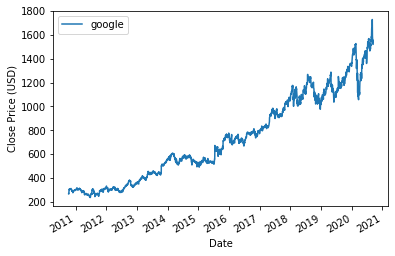

In [11]:
plot_timeseries_label(df, date_col, label_col)

## B. Data Processing

### B.2 Data splits

- Train data: ~1-6 years
- val data: 6-7 years
- Test data: ~7-10 years

- First split by train and test
- Then split train into train and val later

In [12]:
# get year column
df["year"] = df[date_col].dt.date
df["year"] = df["year"].apply(lambda val: val.year)

start_year = min(df["year"].values)
end_year = max(df["year"].values)
duration = end_year - start_year

print("start_year: ", start_year)
print("end_year: ", end_year)
print("duration: ", duration)

start_year:  2010
end_year:  2020
duration:  10


In [13]:
train_df = df.loc[df["year"].isin(list(range(start_year, start_year + 7)))]
test_df = df.loc[df["year"].isin(list(range(start_year + 8, end_year)))]

print("train_df= " , train_df.shape)
print("test_df= " , test_df.shape)

train_df=  (1568, 16)
test_df=  (503, 16)


### B.1 Feature scaling 
https://www.datacamp.com/community/tutorials/lstm-python-stock-market

- With stocks prices, diferent time periods of data will have different value ranges and generally stock prices increase over time
- We need to normalize the data by splitting the full series of the train set into windows. otherwise, earlier data will have value close to 0 and won't help with learning. 
- experiment with different window sizes. make sure they are big enough to capture patterns. 



In [14]:
from sklearn.preprocessing import MinMaxScaler
def fit_scaler(df: pd.DataFrame, window_size = 392):
    """
    Fit and transform scaler on train data using a moving window (to account for moving ranges / non-stationarity)
    scaler = minmax scaler, range from 0 to 1
    - len(train_df) / 4 = 392
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = df[features_list].values

    for i in range(0, len(df), window_size):
        scaler.fit(data[i:i+window_size, :])
        # pdb.set_trace()
        data[i:i+window_size, :] = scaler.transform(data[i:i+window_size, :])

    df[features_list] = data

    return df, scaler

In [15]:
# Fit scaler on train dataset
train_df, scaler = fit_scaler(train_df)

# Scale test dataset based on previously fitted scaler
test_df[features_list] = scaler.transform(test_df[features_list].values)

print("train_df: ", train_df.shape)
print("test_df: ", test_df.shape)

test_df.head()

train_df:  (1568, 16)
test_df:  (503, 16)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,google,microsoft,nvidia,nasdaq,volatility,apple,amazon,ma7,ma21,MACD,upper_band,lower_band,ema,momentum,Date,year
1839,1.850176,1.964579,1.836955,2.086197,-0.050899,1.963096,1.819249,1.905429,1.983924,0.475851,1.936036,1.728563,1.868124,1.850176,2018-01-02,2018
1840,1.909174,1.981857,1.970819,2.135775,-0.071938,1.962377,1.855357,1.915037,1.997174,0.512237,1.935926,1.750096,1.921947,1.909174,2018-01-03,2018
1841,1.922405,2.014687,1.982247,2.167324,-0.069562,1.981548,1.868169,1.928432,2.013248,0.545053,1.939491,1.772986,1.948932,1.922405,2018-01-04,2018
1842,1.975834,2.061339,2.000714,2.197746,-0.069562,2.028756,1.914640,1.951618,2.031037,0.595958,1.962158,1.781958,1.994448,1.975834,2018-01-05,2018
1843,1.991731,2.065227,2.068054,2.224789,-0.059382,2.013180,1.956785,1.980962,2.047265,0.640605,1.989255,1.784533,2.020486,1.991731,2018-01-08,2018


### B.3 Check for NaN values

In [16]:
def check_nan(df: pd.DataFrame, features_list: list):
    """
    Check for which features have nan values
    """
    features = []
    for feature in features_list:
        vals = df[feature].values
        if np.isnan(np.sum(vals)):
            features.append(feature)
    
    return features

In [17]:
# Check to see if there are any nan values in any features
    # nan values will be ignored/masked by lstm model
print("train: %d" %len(check_nan(train_df, features_list)))
print("test: %d" % len(check_nan(test_df, features_list)))

train: 0
test: 0


### B.4 Apply Fourier transform of target stock prices to denoise the signal and extracl global and local trends in the data

In [18]:
from numpy.fft import *
# from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=1e3):
    """
    Apply the fft to the signal
    Compute the frequencies associated with each coefficient
    Keep only the coefficients which have a low enough frequency (in absolute)
    Compute the inverse fft

    """
    fourier = rfft(signal)
    frequencies = rfftfreq(len(signal), d=20e-3/len(signal))
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [19]:
def denoise_fft(df:pd.DataFrame, features_list, label_col):
    """
    Denoise target signal using fourier transform to extract local and global trends
    """
    denoised = filter_signal(df[label_col].values)

    # if ifft results in 1 less element(weird bug), pad with last value
    if len(denoised) < len(df):
        diff = len(df) - len(denoised) 
        # pdb.set_trace()
        denoised = np.asarray(list(denoised) + [denoised[-1]] * diff)

    df["fft"] = denoised

    return df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


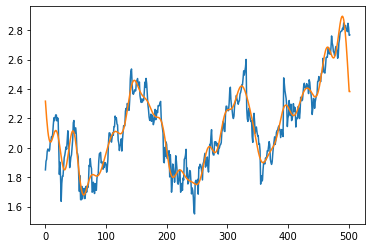

In [20]:
import matplotlib.pyplot as plt

train_df = denoise_fft(train_df, features_list, label_col)
test_df = denoise_fft(test_df, features_list, label_col)

# Visualize FFT denoised data
plt.plot(test_df[label_col].values, label='Raw')
plt.plot(test_df["fft"].values, label='Filtered')
plt.show()

# add feature
features_list.append("fft")

## C. LSTM model (Unidirectional and Bi-directional)

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

- Bidirectional LSTM: 
    - involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - Where LSTM learns linearly, Bidirectional LSTM learns from both past and future to predict current


    


### C.1 Define Custom dataset for LSTM model

In [21]:
import torch
from torch.utils.data import DataLoader, Dataset

class LSTMDataset(Dataset):
    def __init__(self, df:pd.DataFrame, features_list, date_col, time_steps, label_col):
        self.df = df
        self.features_list = features_list
        self.date_col = date_col
        self.time_steps = time_steps
        self.label_col = label_col
        self.data, self.labels = self.prepare_data(df, features_list, date_col, time_steps)
        
    def prepare_data(self, df: pd.DataFrame, features_list: list, date_col: str, time_steps: int):
        """
        Preparing data for CNN = sliding window 

        Inputs:
        df: dataframe of data (train or test)
        uids: uids that correspond to the labels, in correct order
        y: corresponding labels
        features_list: list of features to keep
        time_steps:  number of time_steps, default to 100

        Outputs:
        X data: (num_samples, num_time_steps, num_features)
        y data: (num_samples, )
        """

        # sort by date col
        df = df.sort_values(by=[date_col])
        data = df[self.features_list].values
        targets = df[self.label_col].values

        X_data = []
        y_data = []

        # Rolling window sequence, moves up by 1 data point every time
        for i in range(time_steps, len(data)):
            # Get sequence of length time_steps up till current i - 1
            X_data.append(data[i - time_steps : i])

            # Get stock price at i (label to predict)
            y_data.append(targets[i])

        X_data, y_data = np.array(X_data), np.array(y_data)
        X_data = X_data.reshape(len(X_data), time_steps, len(features_list))

        y_data = y_data.reshape(len(y_data))
        
        return X_data, y_data 
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        """
        X[index] = (time_steps, num_timesteps, features)
        Y[index] = (1)
        """
        X = self.data[index]
        y = self.labels[index].reshape(1)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [22]:
# test dataset
dataset = LSTMDataset(train_df, features_list, date_col, time_steps, label_col)
print("number of features: ", len(features_list))
print("dataset data shape: ", dataset.data.shape)
print("dataset label shape: ", dataset.labels.shape)

number of features:  15
dataset data shape:  (1468, 100, 15)
dataset label shape:  (1468,)


### C.2 Define pytorch LSTM model

In [23]:
import torch
from torch import optim, nn
import pdb

class LSTM(nn.Module):

    def __init__(self, gpu:bool, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional, dr=0.2):
        """
        - num_features: number of features for input
        - hidden_size: number of features for hidden state
        - num_layers: number of recurrent layers (ie. number of LSTM layers)
        - output_size: number of classes to predict
        """
        super(LSTM, self).__init__()

        self.gpu = gpu
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # output_dim set to 1 = predict 1 value
        self.output_dim = output_dim
        self.is_bidirectional = is_bidirectional

        # LSTM layers
            # If your input data is of shape (batch_size, time_steps, features) then you need batch_first=True 
            # If your input data is (time_steps, batch_size, features), then you don't need batch_first=True
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first = True, bidirectional= is_bidirectional)
        self.dropout = nn.Dropout(p = dr)

        if self.is_bidirectional:
            # Linear layer with 1 output dimension to predict 1 value
            self.fc = nn.Linear(hidden_size * 2, self.output_dim)
        
        else:
            # Linear layer with 1 output dimension to predict 1 value
            self.fc = nn.Linear(hidden_size, self.output_dim)

    def forward(self, x):
        # x = (batch_size, time_steps num_features)
        # reset state of LSTM
        h0, c0 = self.init_hidden(x)

        # feed data and hidden states of this batch
        # out = (batch_size, time_steps, hidden_layers) 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # out = self.dropout(out)

        # out = (batch_size, time_steps, output_dim)
        # out[:,-1,:] = (batch_size, output_dim) 
            # get output from the last time step = represent the next prediction
        out = self.fc(out[:,-1,:])

        return out

    def init_hidden(self, x):
        # return zeros 
            # size = (num_layers, batch_size, num_hidden_layers) 
            # ie. for each layer, you have hidden states (= num of hidden layers) for each sample in batch.
        
        if self.is_bidirectional:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_()

        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        if self.gpu:
            return [t.to(self.device) for t in (h0, c0)]
        else:
            return [t for t in (h0, c0)]


### C.3 Train and evalute model on train and val dataset
- save best model
- early stopping enabled for faster training

In [24]:
class AverageMeter(object):
    """
    Function to calculate loss and accuracy during training
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
import pdb

def train(train_loader, optimizer, criterion, model, device):
    """
    Train model for every batch in sample for this current epoch
    """
    # set model to train mode
    model.train()

    train_loss = AverageMeter()

    # go through every batch for this current epoch
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # pdb.set_trace()

        # x_batch = (batch_size, time_step, num_features) 
        x_batch = x_batch.to(device)
        # y_batch = (batch_size, num_features) 
        y_batch = y_batch.to(device)
        N = x_batch.size(0)
        
        # Set gradients to zero before starting to do back propagation because pytorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()

        # y_scores = (batch_size, output_dim)
        y_scores = model(x_batch)

        loss = criterion(y_scores, y_batch)
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item())

    # return average train loss for epoch
    return train_loss.avg

In [26]:
def validate(val_loader, optimizer, criterion, model, device):
    """
    Validate trained model on validation dataset for this epoch
    """
    # set model to eval mode
    model.eval()
    val_loss = AverageMeter()

    # stop gradient descent / back prop during evaluation
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(val_loader):
            # x_batch = (batch_size, time_step, num_features) 
            x_batch = x_batch.to(device)
            # y_batch = (batch_size, num_features)
            y_batch = y_batch.to(device)
            N = x_batch.size(0)

            # y_scores = (batch_size, output_dim) 
            y_scores = model(x_batch)
            loss = criterion(y_scores, y_batch)

            val_loss.update(loss.item())
    
    return val_loss.avg

In [27]:
import tqdm
from tqdm import tqdm

def run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name, early_stop):
    """
    Train and evaluate per epoch and visualize loss over time
    """
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_trained = num_epochs
    best_model = None

    for epoch in range(1, num_epochs + 1): 
        loss_train = train(train_loader, optimizer, criterion, model, device)
        loss_val = validate(val_loader, optimizer, criterion, model, device)

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        print("epoch: ", epoch, "train loss: ", loss_train, "val_loss: ", loss_val)

        # if lowest loss, save model
        if loss_val < best_loss:
            best_loss = loss_val
            es = 0
            torch.save(model.state_dict(), data_path + model_name)
            best_model = model

        else:
            # if loss is not going down
            if early_stop:
            
                # patience count
                es +=1

                if es > patience:
                    epochs_trained = epoch
                    print("Early stopping with lowest loss: ", best_loss)
                    break

    return train_losses, val_losses, epochs_trained, best_model


In [56]:
import matplotlib.pyplot as plt

def run_LSTM(train_df: pd.DataFrame, val_df: pd.DataFrame, is_bidirectional:bool, early_stop: bool, num_features = 1, num_epochs = 100, patience = 20, learning_rate = 0.01, num_layers = 1, hidden_size = 6, output_dim = 1, model_name = "lstm_model_stocks.pt"):
    """
    Run and evaluate LSTM model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(gpu, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional, dr=0.2)
    model.to(device)

    # optimizer = adam
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # loss = MSELoss for regression
    criterion = torch.nn.MSELoss(reduction='mean')

    # data loader:
    train_loader = DataLoader(dataset = LSTMDataset(train_df, features_list, date_col, time_steps, label_col), shuffle = False, batch_size = 32)
    val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps, label_col), shuffle = False, batch_size = 32)

    # run train and evaluation = save best model
    train_losses, val_losses, epochs_trained, best_model = run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name, early_stop)

    # plot train and val losses
    epochs = list(range(1, epochs_trained + 1))
    plt.plot(epochs, train_losses, 'g', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return best_model


In [52]:
# Split into train and validation (15% valid)
train_df = train_df.sort_values(by=[date_col])
valid_idx = int(len(train_df) * 0.15)

val_df = train_df.iloc[:valid_idx]
train_df = train_df.iloc[valid_idx:]

print("train_df: ", train_df.shape)
print("val_df: ", val_df.shape)

train_df:  (964, 17)
val_df:  (170, 17)


epoch:  1 train loss:  0.14305697370286066 val_loss:  0.01948890183120966
epoch:  2 train loss:  0.022944404571144668 val_loss:  0.009626787931968769
epoch:  3 train loss:  0.016772289096412284 val_loss:  0.0006787130259908736
epoch:  4 train loss:  0.010415529681335169 val_loss:  0.0026632584631443024
epoch:  5 train loss:  0.009236289895381089 val_loss:  0.003458789549767971
epoch:  6 train loss:  0.008246756546820203 val_loss:  0.0037199098927279315
epoch:  7 train loss:  0.007435124595994475 val_loss:  0.004007009401296576
epoch:  8 train loss:  0.006843996285978291 val_loss:  0.004012215028827389
epoch:  9 train loss:  0.006407033173470861 val_loss:  0.003949097978572051
epoch:  10 train loss:  0.006079560969266351 val_loss:  0.003799553650120894
epoch:  11 train loss:  0.005819472195408134 val_loss:  0.0035977406272043786
epoch:  12 train loss:  0.00559778110322508 val_loss:  0.0033458128261069455
epoch:  13 train loss:  0.005402297788316867 val_loss:  0.003057821886613965
epoch:

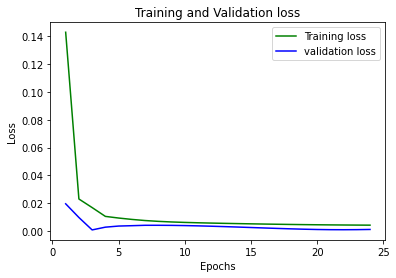

In [57]:
lstm_model = run_LSTM(train_df, val_df, is_bidirectional = False, early_stop= True, num_features = len(features_list))

epoch:  1 train loss:  0.11038505287702989 val_loss:  0.002452662835518519
epoch:  2 train loss:  0.01680914692028805 val_loss:  0.0021226698493895433
epoch:  3 train loss:  0.009995376339820386 val_loss:  0.0009874311120559771
epoch:  4 train loss:  0.006925439194741624 val_loss:  0.0014616676683848102
epoch:  5 train loss:  0.005918871434577914 val_loss:  0.0021251950335378447
epoch:  6 train loss:  0.0056001237621617125 val_loss:  0.002662894936899344
epoch:  7 train loss:  0.00541196615409313 val_loss:  0.002597418613731861
epoch:  8 train loss:  0.00516540451402155 val_loss:  0.002159622342636188
epoch:  9 train loss:  0.004879260700868649 val_loss:  0.001695701425584654
epoch:  10 train loss:  0.004630455696584519 val_loss:  0.001226089894771576
epoch:  11 train loss:  0.004387200359444789 val_loss:  0.0007691034503901998
epoch:  12 train loss:  0.004169797514030641 val_loss:  0.0004986438725609332
epoch:  13 train loss:  0.004036392984239178 val_loss:  0.00042915115288148326
epo

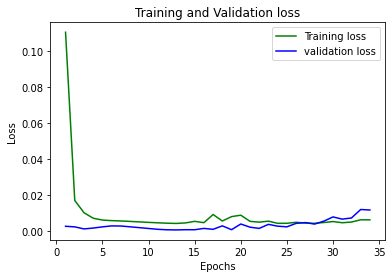

In [61]:
bi_lstm_model = run_LSTM(train_df, val_df, is_bidirectional = True, early_stop= True, num_features = len(features_list))

### C.4 Evalute trained models on val dataset

In [58]:
def evaluate_model(data_loader, model):
    model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    test_loss = AverageMeter()
    y_scores = []
    y_trues = []

    for data, y_true in data_loader:
        # data = (1, time_steps, num_features) =  [1, 100, 1]
        data = data.to(device)
        # y_true = (1, num_features) = [1,1]
        y_true = y_true.to(device)

        y_score = model(data)
        y_scores.append(y_score)
        y_trues.append(y_true)

        loss = criterion(y_score, y_true)
        test_loss.update(loss.item())

    print("loss: ", test_loss.avg)

    return np.asarray(y_scores), np.asarray(y_trues)

In [48]:
def graph_predictions(y_scores, y_trues):
    # plot train and val losses
    time_array = range(1, len(y_scores)+1)

    plt.plot(time_array, y_scores, 'g', label='Prediction')
    plt.plot(time_array, y_trues, 'b', label='Truth')
    plt.title('Stock price prediction')
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

loss:  0.001020723826572326


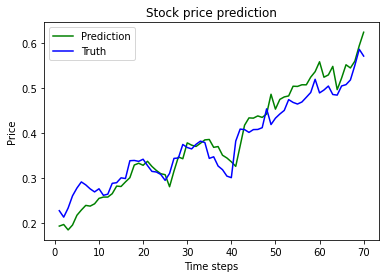

In [59]:
val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps, label_col), shuffle = False)

# Test lstm_model on val dataset
y_scores, y_trues = evaluate_model(val_loader, lstm_model)

graph_predictions(y_scores, y_trues)

loss:  0.012590048302497183


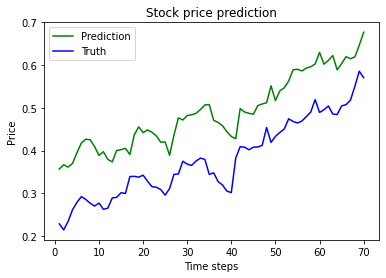

In [62]:
# Test bilstm_model on v
y_scores, y_trues = evaluate_model(val_loader, bi_lstm_model)
graph_predictions(y_scores, y_trues)

### C.5 Evalute trained models on test dataset

loss:  1.1767206901947855


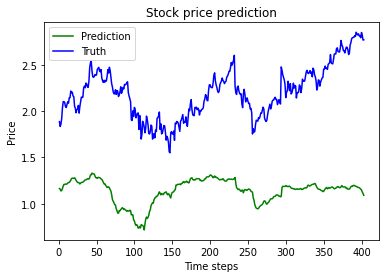

In [60]:
test_loader = DataLoader(dataset = LSTMDataset(test_df, features_list, date_col, time_steps, label_col), shuffle = False)

# Test lstm_model 
y_scores, y_trues = evaluate_model(test_loader, lstm_model)
graph_predictions(y_scores, y_trues)

In [ ]:
# Test bi-lstm model
y_scores, y_trues = evaluate_model(test_loader, bi_lstm_model)
graph_predictions(y_scores, y_trues)